In [ ]:
import pandas as pd, numpy as np, os, gc
from glob import glob
from datetime import datetime
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import pickle
from statsmodels.tsa.stattools import adfuller
# !pip install pmdarima --quiet
import pmdarima as pm

based on:
- https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
- https://github.com/brendanartley/Medium-Article-Code/blob/main/code/time-series-forecasting-w-arima-sarima.ipynb

# Read data

In [ ]:
# Read data
df=pd.read_csv('data/train_imputed.csv', parse_dates=['time']).set_index('time')
val=pd.read_csv('data/validation_imputed.csv', parse_dates=['time']).set_index('time')

In [ ]:
df

,o3,wind,temp,no2,no,nox,year,month_apr,month_aug,month_dec,...,hday_lundi_de_pentecôte,hday_fête_nationale,hday_assomption,hday_toussaint,hday_armistice,hday_noël,hday_jour_de_l_an,hday,hday_after1,hday_before1
time,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00,124.7,3.1,12.9,13.3,0.5,14.0,2021,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 01:00:00,124.7,3.0,12.7,9.7,0.1,9.9,2021,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 02:00:00,124.7,2.9,12.5,7.6,0.1,7.7,2021,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 03:00:00,124.7,3.2,12.6,9.0,0.0,9.1,2021,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-07-01 04:00:00,124.7,2.6,12.1,11.0,0.2,11.5,2021,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 19:00:00,85.1,9.0,19.1,10.7,0.0,10.7,2023,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-06-30 20:00:00,81.1,11.2,17.4,12.9,0.7,13.8,2023,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-06-30 21:00:00,71.4,7.0,16.9,12.5,0.0,12.5,2023,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualize

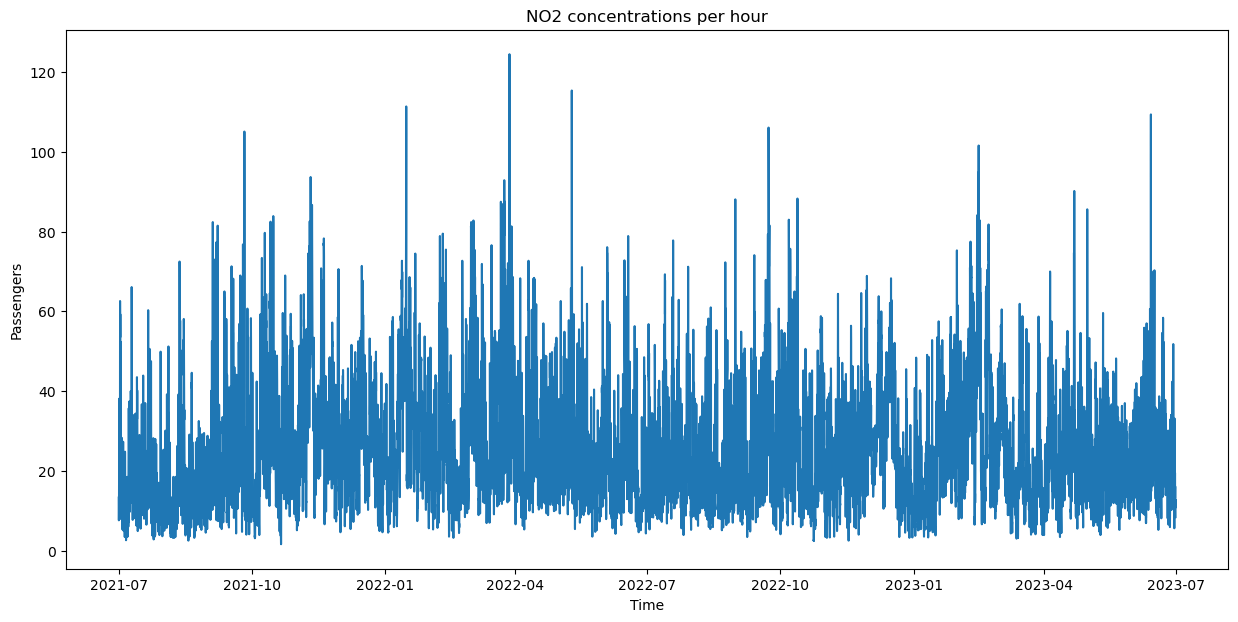

In [ ]:
# Visualize data
plt.figure(figsize=(15,7))
plt.title("NO2 concentrations per hour")
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.plot(df.no2)
plt.show()

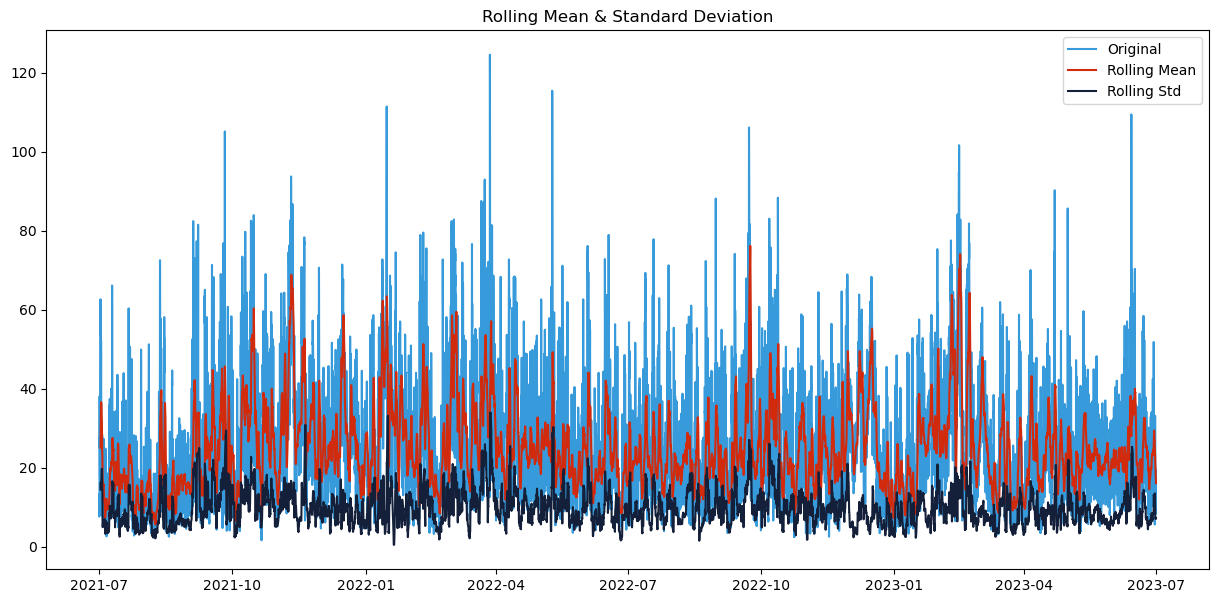

In [ ]:
w=24

#Determine rolling statistics
df["rolling_avg"] = df["no2"].rolling(window=w).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["no2"].rolling(window=w).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["no2"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Check for stationarity
- The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not.
- Null Hypothesis: The data is not stationary.
- to be stationary, p-value <= significance level (0.01, 0.05, 0.10, etc.) (Reject null!)

In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['no2'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                -1.173539e+01
p-value                        1.311461e-21
#Lags Used                     4.400000e+01
Number of Observations Used    1.747500e+04
Critical Value (1%)           -3.430724e+00
Critical Value (5%)           -2.861705e+00
Critical Value (10%)          -2.566858e+00
dtype: float64


# Model

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
1. Standardized residual:
    - There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

2. Histogram plus KDE estimate:
    - The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

3. Normal Q-Q
    - Most of the data points should lie on the straight line

4. Correlogram (ACF plot)
    - 95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

## Functions

In [ ]:
def forecast(ARIMA_model, testdata):
    # Forecast
    n_periods = (len(testdata))#periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
#     index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(hours=1), periods = n_periods, freq='60min')
    index_of_fc = testdata.index

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(testdata["no2"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of NO2")
    plt.show()

    return pd.concat([fitted_series, testdata['no2']], axis=1).rename(columns={0:'pred'})


def sarimax_forecast(SARIMAX_model, testdata, exog_vars, periods=24):
    # Forecast
    n_periods = periods

    forecast_df=testdata.iloc[:n_periods,:]

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[exog_vars])
    forecast_df['pred']=fitted

    # make series for plotting purpose
    fitted_series = forecast_df['pred']
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["no2"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of NO2")
    plt.show()
    return forecast_df

def get_stats(pred):
    """
    Get error statistics
    """
    mae=np.abs(pred['no2']-pred['pred']).mean()
    rmse=np.sqrt((np.abs(pred['no2']-pred['pred'])**2).mean())

    print(f'MAE: {mae}\nRMSE:  {rmse}')

    return mae, rmse

def read_model(pkl):
    # Read pickle file
    with open('models/arima.pkl', 'rb') as pkl:
        model = pickle.load(pkl)
    return model

def save_model(model, file):
    # Serialize with Pickle
    with open(file, 'wb') as pkl:
        pickle.dump(model, pkl)

## ARIMA

In [ ]:
#Standard ARIMA Model: max p and q as 24 (1 day)
ARIMA_model = pm.auto_arima(df['no2'],
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=24, max_q=24, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

In [ ]:
print('pdq order:',ARIMA_model.order)

pdq order: (11, 0, 0)


In [ ]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                17520
Model:              SARIMAX(11, 0, 0)   Log Likelihood              -55798.153
Date:                Tue, 23 Jan 2024   AIC                         111622.306
Time:                        20:01:17   BIC                         111723.331
Sample:                    07-01-2021   HQIC                        111655.572
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7907      0.124     14.486      0.000       1.548       2.033
ar.L1          1.1388      0.004    264.051      0.000       1.130       1.147
ar.L2         -0.2717      0.008    -35.631      0.000      -0.287      -0.257
ar.L3          0.0184      0.009      2.049      0.040       0.001       0.036
ar.L4         -0.0670      0.009     -7.139      0.000      -0.085      -0.049
ar.L5          0.0029      0.010      0.285      0.775      -0.017       0.023
ar.L6         -0.0115      0.010     -1.108      0.268      -0.032       0.009
ar.L7          0.0151      0.010      1.492      0.136      -0.005       0.035
ar.L8          0.0471      0.010      4.889      0.000       0.028       0.066
ar.L9         -0.0131      0.010     -1.272      0.203      -0.033       0.007
ar.L10         0.0488      0.010      4.889      0.000       0.029       0.068
ar.L11         0.0204      0.007      3.103      0.002       0.008       0.033
sigma2        34.1821      0.185    184.439      0.000      33.819      34.545
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             41631.63
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

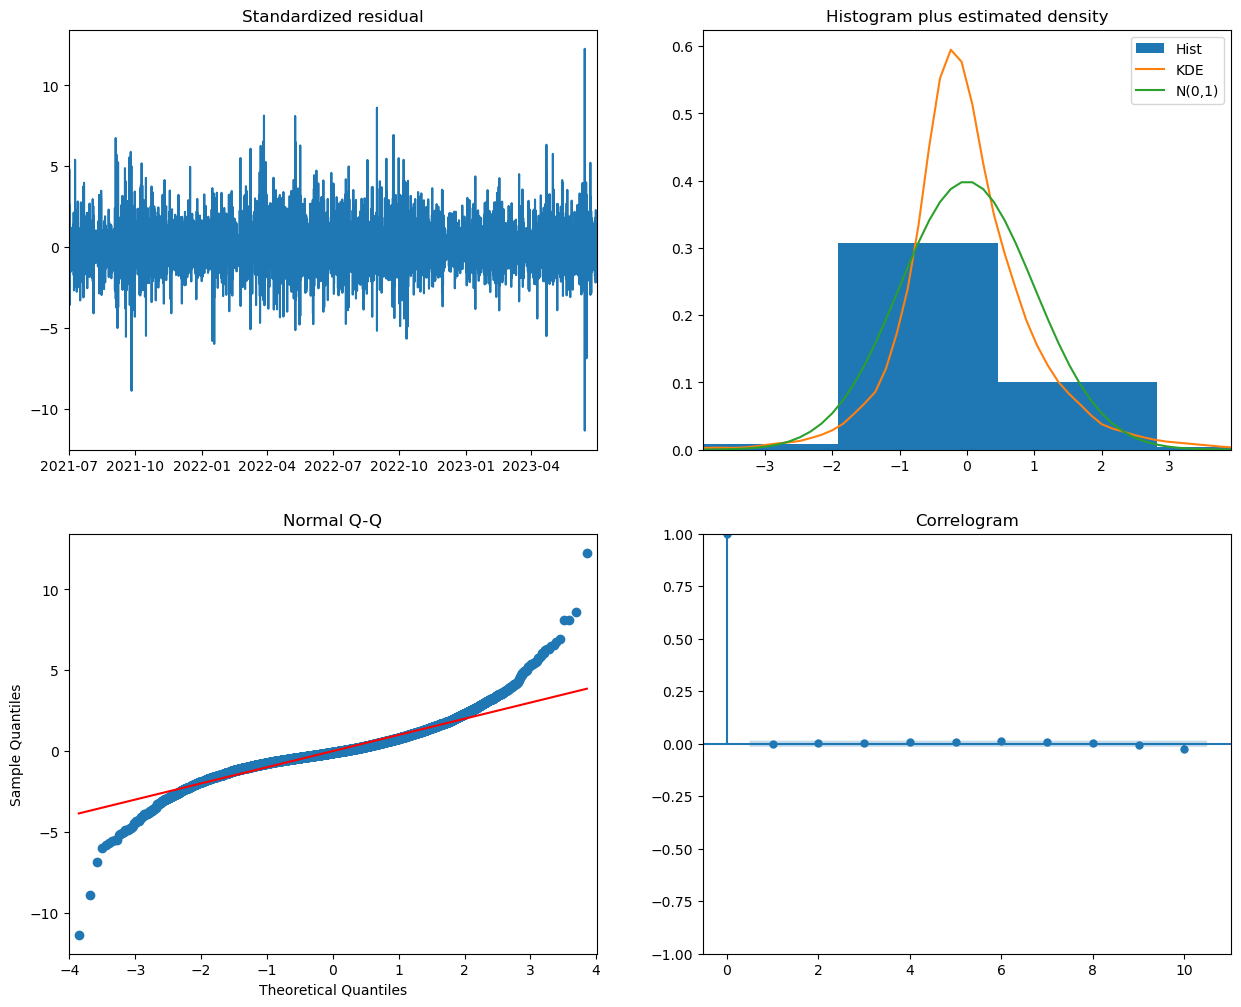

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

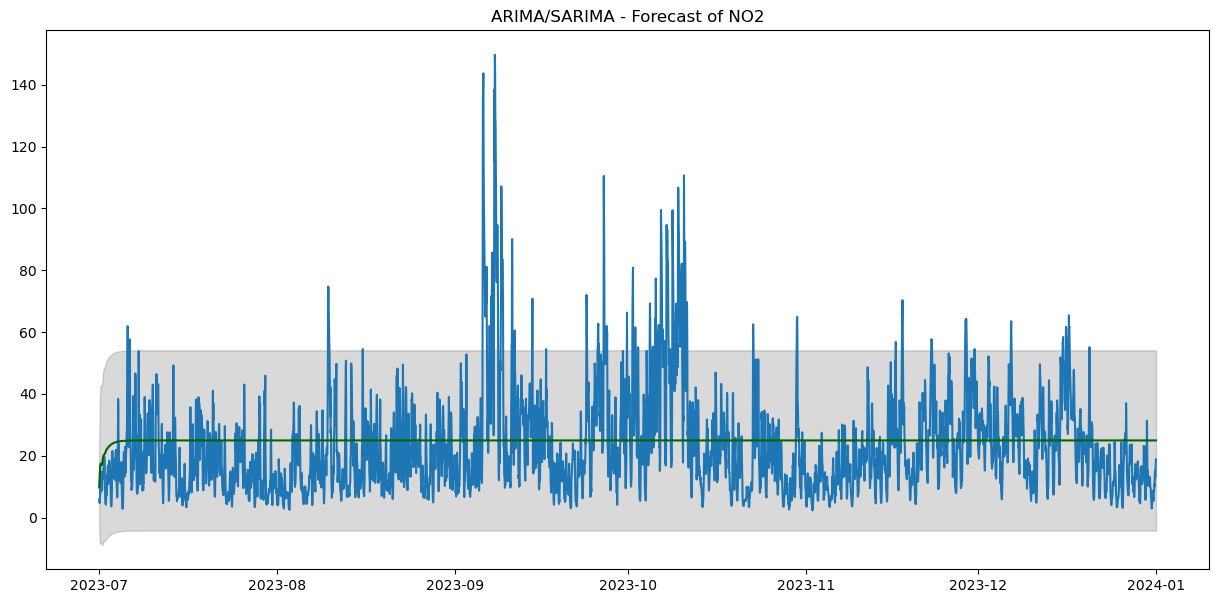

In [ ]:
pred_arima=forecast(ARIMA_model, testdata=val)

In [ ]:
stats_arima=get_stats(pred_arima)

MAE: 12.429445259806828
RMSE:  16.63579770108583


In [ ]:
pred_arima

,pred,no2
time,,
2023-07-01 00:00:00,9.728291,5.8
2023-07-01 01:00:00,11.672450,5.2
2023-07-01 02:00:00,13.359791,4.7
2023-07-01 03:00:00,14.943535,5.3
2023-07-01 04:00:00,16.297094,8.8
...,...,...
2023-12-31 19:00:00,24.942117,15.2
2023-12-31 20:00:00,24.942117,12.9
2023-12-31 21:00:00,24.942117,15.5


In [ ]:
save_model(ARIMA_model, "models/arima2.pkl")

## SARIMA

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["no2"], start_p=6, start_q=6,
                         test='adf',
                         max_p=12, max_q=12,
                         m=8, # frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

MemoryError: Unable to allocate 548. KiB for an array with shape (4, 17520) and data type float64

In [ ]:
save_model(SARIMA_model, "models/sarima2.pkl")

In [ ]:
print('pdq order:',SARIMA_model.order)
print('PDQs order:',SARIMA_model.seasonal_order)
SARIMA_model.summary()

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
pred_sarima=forecast(SARIMA_model, testdata=val)
stats_sarima=get_stats(pred_sarima)
pred_sarima

## SARIMAX

In [ ]:
# SARIMAX Model
exog=['month','hday'] # define exogenous variables
SARIMAX_model = pm.auto_arima(df[['no2']], exogenous=df[exog],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=24, max_q=24, m=168,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
save_model(SARIMAX_model, "models/sarimax.pkl")

In [ ]:
print('Exogenous variables:',', '.join(exog))
print('pdq order:',SARIMAX_model.order)
print('PDQs order:',SARIMAX_model.seasonal_order)
SARIMAX_model.summary()

In [ ]:
pred_sarimax=sarimax_forecast(SARIMAX_model, testdata=val, exog_vars=exog, periods=24)
stats_sarimax=get_stats(pred_sarimax)
pred_sarimax